In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
from helpers import load_and_process_image, display_image

from tensorflow.python.keras.applications.vgg19 import VGG19
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.models import Model

%matplotlib inline

## Import the model

In [2]:
model = VGG19(include_top=False, weights='imagenet')
model.trainable = False
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

## Display content and style images

In [3]:
content_path = 'images/louvre.jpg'
style_path = 'images/monet.jpg'

In [4]:
content = load_and_process_image(content_path)
style = load_and_process_image(style_path)

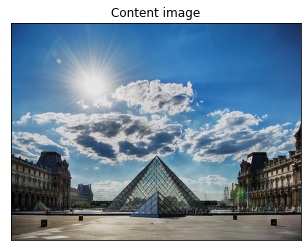

In [5]:
display_image(content, 'Content image')

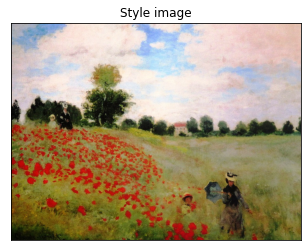

In [6]:
display_image(style, 'Style image')

## Content and style models

In [7]:
content_layer = 'block5_conv2'
style_layers = [
    'block1_conv1',
    'block3_conv1',
    'block5_conv1'
]

In [8]:
content_model = Model(
    inputs=model.input,
    outputs=model.get_layer(content_layer).output
)
style_models = [Model(
    inputs=model.input,
    outputs=model.get_layer(l).output
) for l in style_layers]

## Content cost

In [9]:
def content_cost(content, generated):
    a_C = content_model(content)
    a_G = content_model(generated)
    
    return tf.reduce_mean(tf.square(a_C - a_G))

## Style cost

In [10]:
def gram_matrix(A):
    n_C = int(A.shape[-1]) # number of channels
    # The result will have a shape of (sth, n_C) => for an image it will 
    # be (height x width, num of channels)
    a = tf.reshape(A, [-1, n_C])
    n = tf.shape(a)[0]
    G = tf.matmul(a, a, transpose_a=True)
    
    return G / tf.cast(n, tf.float32)

In [11]:
# Weight of each style layer to compute the style cost.
# We assume that each layer has the same weight
weight = 1 / len(style_models)

In [12]:
def style_cost(style, generated):
    J_style = 0
    
    for style_model in style_models:
        a_S = style_model(style)
        a_G = style_model(generated)
        GS = gram_matrix(a_S)
        GG = gram_matrix(a_G)
        current_cost = tf.reduce_mean(tf.square(GS - GG))
        J_style += current_cost * weight
        
    return J_style

## Train the model

In [13]:
generated_images = []

def training_loop(iterations=20, alpha=10, beta=20, learning_rate=7):
    generated = tf.Variable(content, dtype=tf.float32)
    opt = tf.keras.optimizers.Adam(learning_rate)
    
    best_cost = 1e12
    best_image = None
    start_time = time.time()
    
    for i in range(iterations):
        with tf.GradientTape() as tape:
            J_content = content_cost(content, generated)
            J_style = style_cost(style, generated)
            J_total = alpha * J_content + beta * J_style
            
        grads = tape.gradient(J_total, generated)
        opt.apply_gradients([(grads, generated)])
        
        if J_total < best_cost:
            best_cost = J_total
            best_image = generated
            
        print('Cost at {}: {}. Time elapsed: {}'.format(i, J_total, time.time() - start_time))
        generated_images.append(generated.numpy())
        
    return best_image

In [ ]:
best_image = training_loop(iterations=100)

Cost at 0: 1505038336.0. Time elapsed: 38.646429777145386
Cost at 1: 939493056.0. Time elapsed: 75.66206312179565
Cost at 2: 606972864.0. Time elapsed: 112.73774003982544
Cost at 3: 447142240.0. Time elapsed: 150.95663595199585
Cost at 4: 315966624.0. Time elapsed: 188.2774760723114
Cost at 5: 247997008.0. Time elapsed: 225.34383296966553
Cost at 6: 208585232.0. Time elapsed: 262.4211299419403
Cost at 7: 180447200.0. Time elapsed: 299.5325608253479
Cost at 8: 161690064.0. Time elapsed: 336.4467890262604
Cost at 9: 143967136.0. Time elapsed: 373.8231749534607
Cost at 10: 126787288.0. Time elapsed: 412.4527950286865
Cost at 11: 113831104.0. Time elapsed: 449.21812987327576
Cost at 12: 103185496.0. Time elapsed: 487.03023409843445
Cost at 13: 93587680.0. Time elapsed: 525.4608979225159
Cost at 14: 85541712.0. Time elapsed: 562.3544769287109
Cost at 15: 77939832.0. Time elapsed: 599.1852219104767
Cost at 16: 70390664.0. Time elapsed: 635.7727389335632
Cost at 17: 64048696.0. Time elapsed: 

## Plot the results

In [ ]:
display_image(best_image)

In [ ]:
plt.figure(figsize=(10,10))

for i in range(20):
    plt.subplot(5, 4, i+1)
    display_image(generated_images[i])